In [ ]:
import numpy
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def data_preparation(Dataset_Class, Mean, Std, Kernel, Batch_Size = 128, Shuffle = False):
  transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(Mean, Std),transforms.GaussianBlur(Kernel)])
  train_dataset = Dataset_Class(root = "./data", train = True, download = True, transform = transform)
  train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = Batch_Size, shuffle = Shuffle)
  test_dataset = Dataset_Class(root = "./data", train = False, download = True, transform = transform)
  test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = Batch_Size, shuffle = Shuffle)
  return train_loader, test_loader

In [ ]:
class AE_1(torch.nn.Module):
  def __init__(self,input_size, bottle_neck):
    super().__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_size, int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/2), int(input_size/4)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/4), int(input_size/8)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/8), bottle_neck),
        torch.nn.ReLU())
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(bottle_neck, int(input_size/8)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/8), int(input_size/4)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/4), int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/2), int(input_size)),
        torch.nn.ReLU())
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

class AE_2(torch.nn.Module):
  def __init__(self,input_size, bottle_neck):
    super().__init__()
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_size, input_size+int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(input_size+int(input_size/2), 2*input_size),
        torch.nn.ReLU(),
        torch.nn.Linear(2*input_size, (2*input_size)+int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear((2*input_size)+int(input_size/2), bottle_neck),
        torch.nn.ReLU())
    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(bottle_neck, (2*input_size)+int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear((2*input_size)+int(input_size/2), 2*input_size),
        torch.nn.ReLU(),
        torch.nn.Linear(2*input_size, input_size+int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(input_size+int(input_size/2), int(input_size)),
        torch.nn.ReLU())
  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
class FC_11(torch.nn.Module):
  def __init__(self,input_size, output_classes):
    super().__init__()
    self.block = torch.nn.Sequential(
        torch.nn.Linear(input_size,int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/2),output_classes),
        torch.nn.Softmax())
  def forward(self, x):
    output = self.block(x)
    return output

class FC_12(torch.nn.Module):
  def __init__(self,input_size, output_classes):
    super().__init__()
    self.block = torch.nn.Sequential(
        torch.nn.Linear(input_size,int(input_size/2)),
        torch.nn.LeakyReLU(negative_slope=0.05),
        torch.nn.Linear(int(input_size/2),output_classes),
        torch.nn.Softmax())
  def forward(self, x):
    output = self.block(x)
    return output

class FC_31(torch.nn.Module):
  def __init__(self,input_size, output_classes):
    super().__init__()
    self.block = torch.nn.Sequential(
        torch.nn.Linear(input_size,int(input_size/2)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/2),int(input_size/4)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/4),int(input_size/8)),
        torch.nn.ReLU(),
        torch.nn.Linear(int(input_size/8),output_classes),
        torch.nn.Softmax())
  def forward(self, x):
    output = self.block(x)
    return output

class FC_32(torch.nn.Module):
  def __init__(self,input_size, output_classes):
    super().__init__()
    self.block = torch.nn.Sequential(
        torch.nn.Linear(input_size,int(input_size/2)),
        torch.nn.LeakyReLU(negative_slope=0.05),
        torch.nn.Linear(int(input_size/2),int(input_size/4)),
        torch.nn.LeakyReLU(negative_slope=0.05),
        torch.nn.Linear(int(input_size/4),int(input_size/8)),
        torch.nn.LeakyReLU(negative_slope=0.05),
        torch.nn.Linear(int(input_size/8),output_classes),
        torch.nn.Softmax())
  def forward(self, x):
    output = self.block(x)
    return output

In [ ]:
def grad_change(Loss_Function, Optimizer, Supervised=False, Image = None, Reconstructed = None, Label = None, Predicted = None):
  Optimizer.zero_grad()
  if Supervised==True:
    loss = Loss_Function(Predicted, Label)
  else:
    loss = Loss_Function(Reconstructed, Image)
  loss.backward()
  Optimizer.step()
  return loss, Optimizer

def train_model(Train_Loader, Epochs, Model_Class_AutoEncoder=None, Model_Class_FC_Block=None, Loss_Function=None, Optimizer=None, Supervised=False):
  outputs=[]
  for Epoch in range(Epochs):
    running_loss=0
    if Supervised==True:
      for (image, label) in Train_Loader:
        image = image.reshape(-1,784).cuda()
        label = label.cuda()
        output = Model_Class_AutoEncoder(image)
        out = Model_Class_FC_Block(output)
        loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Supervised = Supervised, Label = label, Predicted = out)
        running_loss += loss.item()
      predicted = out.data.max(1, keepdim=True)[1]
      outputs.append((Epoch, running_loss, label, predicted))
    else:
      for (image, _) in Train_Loader:
        image = image.reshape(-1,784).cuda()
        out = Model_Class_AutoEncoder(image)
        loss, Optimizer = grad_change(Loss_Function = Loss_Function, Optimizer = Optimizer, Supervised = Supervised, Image=image, Reconstructed=out)
        running_loss += loss.item()
      outputs.append((Epoch, running_loss, image, out))
  return Model_Class_AutoEncoder, Model_Class_FC_Block, outputs

def evaluate_model(Test_Loader, Model_Class_AutoEncoder=None, Model_Class_FC_Block=None, Loss_Function=None, Supervised=False):
  outputs=[]
  running_loss=0
  correct=0
  if Supervised==True:
    with torch.no_grad():
      for (image, label) in Test_Loader:
        image = image.reshape(-1,784).cuda()
        label = label.cuda()
        output = Model_Class_AutoEncoder(image)
        out = Model_Class_FC_Block(output)
        loss = Loss_Function(out,label)
        running_loss += loss.item()
        predicted = out.data.max(1, keepdim=True)[1]
        correct += predicted.eq(label.data.view_as(predicted)).sum()
      outputs.append((running_loss/len(Test_Loader), 100*correct/len(Test_Loader.dataset)))
  else:
    with torch.no_grad():
      for (image, _) in Test_Loader:
        image = image.reshape(-1,784).cuda()
        out = Model_Class_AutoEncoder(image)
        loss = Loss_Function(out, image)
        running_loss += loss.item()
      outputs.append((running_loss/len(Test_Loader), image, out))
  return outputs

In [ ]:
model_1 = AE_1(input_size=784, bottle_neck=128).cuda()
loss_function_1 = torch.nn.MSELoss().cuda()
optimizer_1 = torch.optim.Adam(model_1.parameters())

model_2 = AE_2(input_size=784, bottle_neck=2048).cuda()
loss_function_2 = torch.nn.MSELoss().cuda()
optimizer_2 = torch.optim.Adam(model_2.parameters())

In [ ]:
train, test = data_preparation(datasets.MNIST, 0, 1, (3,3), 256, Shuffle=False)

In [ ]:
model_1, _, output_1 = train_model(Train_Loader=train, Epochs=10, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=None, Loss_Function=loss_function_1, Optimizer=optimizer_1, Supervised=False)
model_2, _, output_2 = train_model(Train_Loader=train, Epochs=10, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=None, Loss_Function=loss_function_2, Optimizer=optimizer_2, Supervised=False)

In [ ]:
loss_train_classifiers = []
loss_test_classifiers = []
acc_train = []
acc_test = []

for i in tqdm([2,4,6,8,10]):

  classifier_11 = FC_11(input_size=784, output_classes=10).cuda()
  loss_function_11 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_11 = torch.optim.Adam(classifier_11.parameters())
  
  classifier_12 = FC_12(input_size=784, output_classes=10).cuda()
  loss_function_12 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_12 = torch.optim.Adam(classifier_12.parameters())
  
  classifier_31 = FC_31(input_size=784, output_classes=10).cuda()
  loss_function_31 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_31 = torch.optim.Adam(classifier_31.parameters())
  
  classifier_32 = FC_32(input_size=784, output_classes=10).cuda()
  loss_function_32 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_32 = torch.optim.Adam(classifier_32.parameters())
  
  model_1, classifier_11, output_11 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_11, Loss_Function=loss_function_11, Optimizer=optimizer_11, Supervised=True)
  model_1, classifier_12, output_12 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_12, Loss_Function=loss_function_12, Optimizer=optimizer_12, Supervised=True)
  model_1, classifier_31, output_31 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_31, Loss_Function=loss_function_31, Optimizer=optimizer_31, Supervised=True)
  model_1, classifier_32, output_32 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_32, Loss_Function=loss_function_32, Optimizer=optimizer_32, Supervised=True)
  output_t11 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_11, Loss_Function=loss_function_11, Supervised=True)
  output_t12 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_12, Loss_Function=loss_function_12, Supervised=True)
  output_t31 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_31, Loss_Function=loss_function_31, Supervised=True)
  output_t32 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_32, Loss_Function=loss_function_32, Supervised=True)
  output_f11 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_11, Loss_Function=loss_function_11, Supervised=True)
  output_f12 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_12, Loss_Function=loss_function_12, Supervised=True)
  output_f31 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_31, Loss_Function=loss_function_31, Supervised=True)
  output_f32 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_1, Model_Class_FC_Block=classifier_32, Loss_Function=loss_function_32, Supervised=True)
  loss_train_classifiers.append([output_11[-1][1],output_12[-1][1],output_31[-1][1],output_32[-1][1]])
  loss_test_classifiers.append([output_f11[0][0],output_f12[0][0],output_f31[0][0],output_f32[0][0]])
  acc_train.append([output_t11[0][1],output_t12[0][1],output_t31[0][1],output_t32[0][1]])
  acc_test.append([output_f11[0][1],output_f12[0][1],output_f31[0][1],output_f32[0][1]])

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 5/5 [1:07:07<00:00, 805.47s/it]


In [ ]:
loss_train_classifiers_2 = []
loss_test_classifiers_2 = []
acc_train_2 = []
acc_test_2 = []

for i in tqdm([2,4,6,8,10]):

  classifier_11 = FC_11(input_size=784, output_classes=10).cuda()
  loss_function_11 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_11 = torch.optim.Adam(classifier_11.parameters())
  
  classifier_12 = FC_12(input_size=784, output_classes=10).cuda()
  loss_function_12 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_12 = torch.optim.Adam(classifier_12.parameters())
  
  classifier_31 = FC_31(input_size=784, output_classes=10).cuda()
  loss_function_31 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_31 = torch.optim.Adam(classifier_31.parameters())
  
  classifier_32 = FC_32(input_size=784, output_classes=10).cuda()
  loss_function_32 = torch.nn.CrossEntropyLoss().cuda()
  optimizer_32 = torch.optim.Adam(classifier_32.parameters())
  
  model_2, classifier_11, output_11 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_11, Loss_Function=loss_function_11, Optimizer=optimizer_11, Supervised=True)
  model_2, classifier_12, output_12 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_12, Loss_Function=loss_function_12, Optimizer=optimizer_12, Supervised=True)
  model_2, classifier_31, output_31 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_31, Loss_Function=loss_function_31, Optimizer=optimizer_31, Supervised=True)
  model_2, classifier_32, output_32 = train_model(Train_Loader=train, Epochs=i, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_32, Loss_Function=loss_function_32, Optimizer=optimizer_32, Supervised=True)
  output_t11 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_11, Loss_Function=loss_function_11, Supervised=True)
  output_t12 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_12, Loss_Function=loss_function_12, Supervised=True)
  output_t31 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_31, Loss_Function=loss_function_31, Supervised=True)
  output_t32 = evaluate_model(Test_Loader = train, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_32, Loss_Function=loss_function_32, Supervised=True)
  output_f11 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_11, Loss_Function=loss_function_11, Supervised=True)
  output_f12 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_12, Loss_Function=loss_function_12, Supervised=True)
  output_f31 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_31, Loss_Function=loss_function_31, Supervised=True)
  output_f32 = evaluate_model(Test_Loader = test, Model_Class_AutoEncoder=model_2, Model_Class_FC_Block=classifier_32, Loss_Function=loss_function_32, Supervised=True)
  loss_train_classifiers_2.append([output_11[-1][1],output_12[-1][1],output_31[-1][1],output_32[-1][1]])
  loss_test_classifiers_2.append([output_f11[0][0],output_f12[0][0],output_f31[0][0],output_f32[0][0]])
  acc_train_2.append([output_t11[0][1],output_t12[0][1],output_t31[0][1],output_t32[0][1]])
  acc_test_2.append([output_f11[0][1],output_f12[0][1],output_f31[0][1],output_f32[0][1]])

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 5/5 [1:09:02<00:00, 828.55s/it]


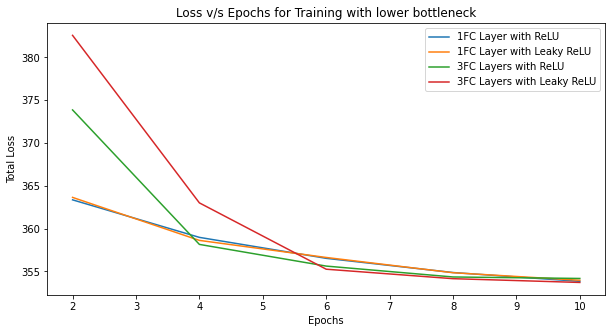

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[loss_train_classifiers[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_train_classifiers[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_train_classifiers[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_train_classifiers[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Loss v/s Epochs for Training with lower bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

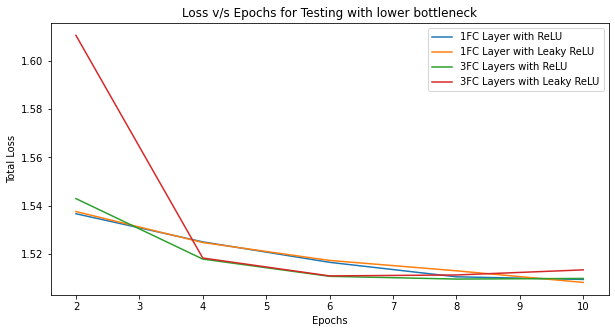

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[loss_test_classifiers[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_test_classifiers[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_test_classifiers[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_test_classifiers[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Loss v/s Epochs for Testing with lower bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

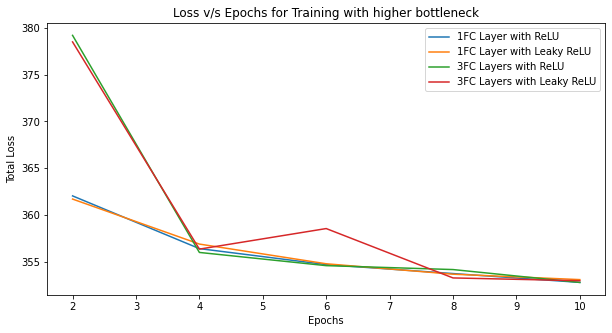

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[loss_train_classifiers_2[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_train_classifiers_2[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_train_classifiers_2[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_train_classifiers_2[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Loss v/s Epochs for Training with higher bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

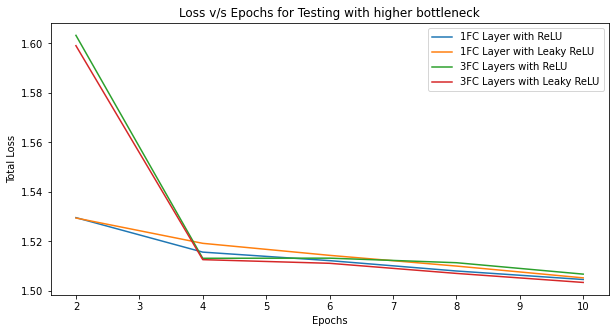

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[loss_test_classifiers_2[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_test_classifiers_2[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_test_classifiers_2[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[loss_test_classifiers_2[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Loss v/s Epochs for Testing with higher bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

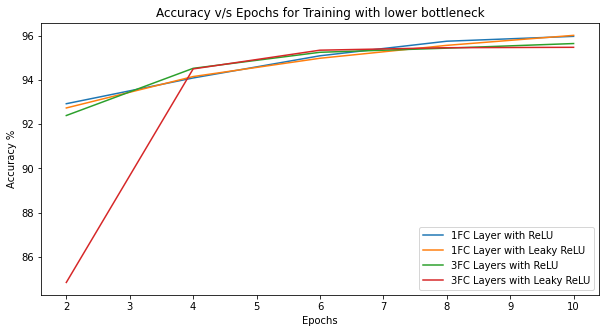

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[acc_train[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_train[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_train[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_train[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with lower bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

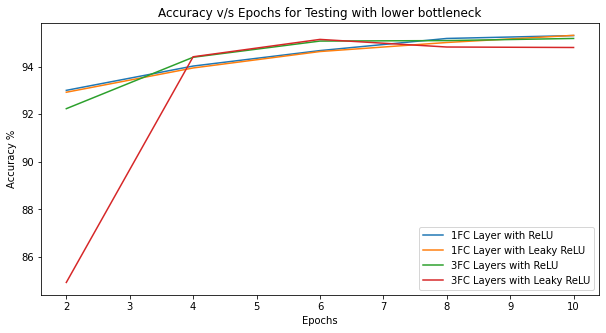

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[acc_test[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_test[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_test[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_test[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with lower bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

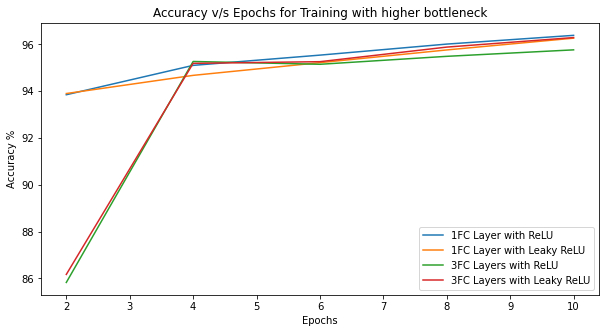

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[acc_train_2[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_train_2[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_train_2[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_train_2[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Training with higher bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()

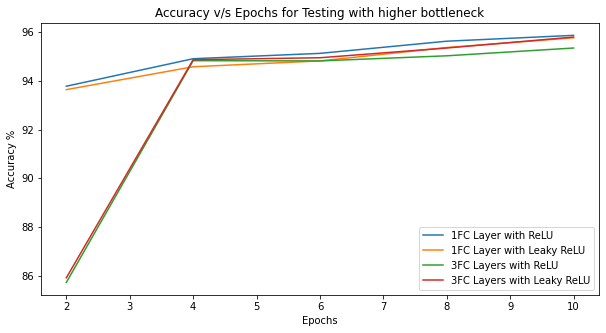

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([2,4,6,8,10],[acc_test_2[i][0] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_test_2[i][1] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_test_2[i][2] for i in range(0,5)])
plt.plot([2,4,6,8,10],[acc_test_2[i][3] for i in range(0,5)])
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.title("Accuracy v/s Epochs for Testing with higher bottleneck")
plt.legend(["1FC Layer with ReLU","1FC Layer with Leaky ReLU","3FC Layers with ReLU","3FC Layers with Leaky ReLU"])
plt.show()